In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix, hstack
from sklearn.cluster import KMeans
import pickle
from collections import Counter
def savePickle(target, filename):
    with open(filename, "wb") as f:
        pickle.dump(target, f)
def loadPickle(filename):
    with open(filename, "rb") as f:
        return pickle.load(f)

 - 1_total_fee array([ 0.39827125,  0.39316978,  0.39571121])
 - 2_total_fee _array([ 0.34979964,  0.35166863,  0.35014922])
 - 3_total_fee array([ 0.34979964,  0.35166863,  0.35014922])
 - 4_total_fee  array([ 0.3525123 ,  0.35381964,  0.35444017])
 - 1234 array([ 0.56280605,  0.56499034,  0.56352438])
 c =  array([ 0.29369751,  0.29296579,  0.29410951])
 ---------------------------------------------------
 ####  total fee
  - 1234 0.5604
  - 1234 + 1/2 0.5630
  - 1234 +1/2 1/3 0.5648
  - 1234 + 1/2+1/3+2/4 0.5651
  - 1234 + 1/2 1/3 1/4 2/3 2/4 0.5662
  - 1234 + 1/2 1/3 1/4 2/3 2/4 1/234 0.5665
  - 1234 + 1/2 1/3 1/4 2/3 2/4 3/4 1/234 0.5674
  
#### traffic
  - fee + local 0.5994
  - fee + local + last 0.7095
  - fee + local _ last + month 0.7472
  - fee + local _ last + month +  last/month 0.7476
  - fee + local _ last + month +  last/month local/month 0.7493
  
#### call
  -  fee + traffic + local 0.7519
  -  fee + traffic + local + service1 0.7850
  -  fee + traffic + local + service1 + service2  0.8160
  -  fee + traffic + local + service1 + service2 + s2/local 0.8162
  
#### nature
  - fee + traffic + call + age  0.8184
  - fee + traffic + call + age + gender 0.8189
  
#### statistics
  - fee + traffic + call + age + onlinetime 0.0.8280
  - fee + traffic + call + age + onlinetime + service_type 0.8352
  - fee + traffic + call + age + onlinetime + service_type + is_mix_type 0.8362
  - ... +  many_over_bill 0.8443
  - ... +  contract_type 0.8496
  - ... + contract_time 0.8683
  - ... + is_promise_low_consume 0.8689
  - ... + pay_times 0.8690
  - ... + pay_num 0.8693
#### cross feature
  - ... + traffic/fee 0.8699
  - ... + traffic/call 0.8701
  - ... 8839， 0.8843

In [2]:
def square_f1_score(y_true, y_pred):
    y_pred = np.array(y_pred)
    y_true = np.array(y_true)
    samples = len(y_true)
    classes = int(len(y_pred)/samples)
    df = pd.DataFrame()
    for i in range(0, classes):
        df['c_%d'%i] =  y_pred[samples * i: samples*(i+1)]
    pred = np.argmax(np.array(df), axis = 1)
    score = np.square(f1_score(y_true, pred, average = 'macro'))
    return 'square_f1_score', score, True

In [3]:
def getfeeDistance(fee1, fee2):
    #计算规范化之后，1_totol_fee 和 2_total_fee 组成的二维图中，样本离对角线的距离。
    n1_fee = np.log(fee1 + 1)
    n1_fee = n1_fee/np.max(n1_fee)
    n2_fee = np.log(fee2 + 1)
    n2_fee = n1_fee/np.max(n2_fee)
    d_fee_1_2 = abs(n1_fee - n2_fee)/1.4142
    d_fee12_o = np.sqrt(np.power(n1_fee, 2) + np.power(n2_fee, 2))
    return d_fee_1_2, d_fee12_o

def normalize(feature, log = True, percent = -1):
    c = np.array(feature)
    if 0 < percent < 100:
        top = np.percentile(c, 100 - percent)
        bottom = np.percentile(c, percent)
        maxv = top + 2*(top - bottom)
        minv = bottom - 2*(top - bottom)
        c = np.array([maxv if v > maxv else v for v in c ])
        c = np.array([minv if v < minv else v for v in c ])
        print(top, bottom, maxv, minv)
    if log:
        c = np.log(c + 1)
    c = c/np.max(c)
    return c
    

In [4]:

enc = OneHotEncoder()
train = loadPickle("../data/train.pkl")
test = loadPickle("../data/test.pkl")
test['2_total_fee'] = test['2_total_fee'].astype(float)
test['3_total_fee'] = test['3_total_fee'].astype(float)
test['3_total_fee'] = test['3_total_fee'].astype(float)
categoryes = sorted(train['current_service'].unique())
label_dict = {}
for i in range(len(categoryes)):
    label_dict[categoryes[i]] = i
    label_dict[i] = categoryes[i]

test['current_service'] = -1
train['current_service'] = np.array(train['current_service'].apply(lambda x:label_dict[x]))
train = train.append(test)
features = train[['1_total_fee', '2_total_fee', '3_total_fee', '4_total_fee']].copy()
features['1_2_total_fee_n'] = np.array(features['1_total_fee'])/np.array(features['2_total_fee'])
features['1_3_total_fee_n'] = np.array(features['1_total_fee'])/np.array(features['3_total_fee'])
features['2_4_total_fee_n'] = np.array(features['2_total_fee'])/np.array(features['4_total_fee'])
features['2_3_total_fee_n'] = np.array(features['2_total_fee'])/np.array(features['3_total_fee'])
features['3_4_total_fee_n'] = np.array(features['3_total_fee'])/np.array(features['4_total_fee'])
features.loc[features['2_total_fee'] == 0, '1_2_total_fee_n'] =  -1
features.loc[features['3_total_fee'] == 0, '1_3_total_fee_n'] =  -1
features.loc[features['4_total_fee'] == 0, '2_4_total_fee_n'] =  -1
features.loc[features['3_total_fee'] == 0, '2_3_total_fee_n'] =  -1
features.loc[features['4_total_fee'] == 0, '3_4_total_fee_n'] =  -1
features['max_fee'] = np.max(np.array(features[['1_total_fee', '2_total_fee', '3_total_fee', '4_total_fee']]),axis = 1)
features['min_fee'] = np.min(np.array(features[['1_total_fee', '2_total_fee', '3_total_fee', '4_total_fee']]),axis = 1)
# traficc
features['local_trafffic_month'] = train['local_trafffic_month']
features['last_month_traffic'] = train['last_month_traffic']
features['month_traffic'] = normalize(train['month_traffic'], log = True, percent = 25)
features['r_last_month_traffic'] = np.array(train['last_month_traffic'])/np.array(train['month_traffic'])
features['r_local_month_traffic'] = np.array(train['local_trafffic_month'])/np.array(train['month_traffic'])
features.loc[features['month_traffic'] == 0, 'r_last_month_traffic'] =  -1
features.loc[features['month_traffic'] == 0, 'r_local_month_traffic'] =  -1
features['r_last_month_traffic'] = normalize(features['r_last_month_traffic'], log = True, percent = 25)
features['r_local_month_traffic'] = normalize(features['r_local_month_traffic'], log = True, percent = 25)
features['non_local_trafffic_month'] = np.array(train['month_traffic']) - np.array(train['local_trafffic_month'])

#call
features['local_caller_time'] = train['local_caller_time']
features['service1_caller_time'] = train['service1_caller_time']
features['service2_caller_time'] = train['service2_caller_time']
features['s2_local_caller_time'] = np.array(train['service2_caller_time'])/np.array(train['local_caller_time'])
features['s1_s2_caller_time'] = np.array(train['service1_caller_time'])/np.array(train['service2_caller_time'])
features.loc[features['local_caller_time'] == 0, 's2_local_caller_time'] =  -1
features.loc[features['service2_caller_time'] == 0, 's1_s2_caller_time'] =  -1
features['s2_local_caller_time'] = normalize(features['s2_local_caller_time'], log = True, percent = 25)
features['s1_s2_caller_time'] = normalize(features['s1_s2_caller_time'], log = True, percent = 25)
#nature
features['age'] = train['age']
features['gender0'] = np.array(train['gender'] == 0).astype(int)
features['gender1'] = np.array(train['gender'] == 1).astype(int)
features['gender2'] = np.array(train['gender'] == 2).astype(int)

#other
features['online_time'] = train['online_time']
features['service_type0'] = np.array(train['service_type'] == 4).astype(int)
features['service_type1'] = np.array(train['service_type'] == 1).astype(int)
features['is_mix_service'] = train['is_mix_service']
features['many_over_bill'] = train['many_over_bill']
features['contract_type0'] = np.array(train['contract_type'] == 0).astype(int)
features['contract_type1'] = np.array(train['contract_type'] == 1).astype(int)
features['contract_type2'] = np.array(train['contract_type'] == 2).astype(int)
features['contract_type3'] = np.array(train['contract_type'] == 3).astype(int)
features['contract_type4'] = np.array(train['contract_type'] == 6).astype(int)
features['contract_type5'] = np.array(train['contract_type'] == 7).astype(int)
features['contract_type6'] = np.array(train['contract_type'] == 8).astype(int)
features['contract_type7'] = np.array(train['contract_type'] == 9).astype(int)
features['contract_type8'] = np.array(train['contract_type'] == 12).astype(int)
for t in sorted(train['contract_time'].unique()):
    features['contract_time_%d'%t] = np.array(train['contract_time'] == t).astype(int)
features['is_promise_low_consume'] = train['is_promise_low_consume']
# for t in sorted(train['net_service'].unique()):
#     features['net_service_%d'%t] = np.array(train['net_service'] == t).astype(int) not good
features['pay_times'] = train['pay_times']
features['pay_num'] = train['pay_num']

# cross
features['traffic_fee'] = normalize(train['month_traffic'])/normalize(train['1_total_fee'])
features.loc[features['1_total_fee'] == 0, 'traffic_fee'] =  -1
features['traffic_fee'] = normalize(features['traffic_fee'], log = False, percent = 25)

#计算规范化之后，1_totol_fee 和 2_total_fee 组成的二维图中，样本离对角线的距离。
features['d_fee_1_2'], features['d_fee12_o'] = getfeeDistance(features['1_total_fee'], features['2_total_fee'])
features['d_fee_2_3'], features['d_fee23_o'] = getfeeDistance(features['2_total_fee'], features['3_total_fee'])
features['d_fee_3_4'], features['d_fee34_o'] = getfeeDistance(features['3_total_fee'], features['4_total_fee'])

#计算相等金额离散化值
e12 = np.array(train['1_total_fee'] == train['2_total_fee'])

c1 = normalize(features['local_trafffic_month'])
c2 = normalize(features['month_traffic'])
c2 = np.power(c2,0.0625)
features['traffic_magic'] = c1 - c2

c1 = normalize(features['local_caller_time'])
c2 = normalize(features['service1_caller_time'])
features['d_local_service1'] = c1 - c2
features['d_local_service2'] =  c2 + c2



# userid 
features['user_id'] = train['user_id']
features['current_service'] = train['current_service']

features = features.fillna(-1)
train = features[features.current_service >= 0].copy()
test = features[features.current_service < 0].drop(['current_service'], axis = 1).copy()

C:\Users\leo\Anaconda3\envs\tensorflow_gpu\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\leo\Anaconda3\envs\tensorflow_gpu\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
C:\Users\leo\Anaconda3\envs\tensorflow_gpu\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\leo\Anaconda3\envs\tensorflow_gpu\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide
C:\Users\leo\Anaconda3\envs\tensorflow_gpu\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\leo\Anaconda3\envs\tensorflow_gpu\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
C:\Users\leo\Anaconda3\envs\tensorflow_gpu\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in 

1375.0167501 0.0 4125.05025029 -2750.03350019


C:\Users\leo\Anaconda3\envs\tensorflow_gpu\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\leo\Anaconda3\envs\tensorflow_gpu\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
C:\Users\leo\Anaconda3\envs\tensorflow_gpu\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\leo\Anaconda3\envs\tensorflow_gpu\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


0.184855691419 -1.0 2.55456707426 -3.36971138284


C:\Users\leo\Anaconda3\envs\tensorflow_gpu\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log


0.990473448318 -1.0 4.97142034495 -4.98094689664


C:\Users\leo\Anaconda3\envs\tensorflow_gpu\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\leo\Anaconda3\envs\tensorflow_gpu\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide
C:\Users\leo\Anaconda3\envs\tensorflow_gpu\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\leo\Anaconda3\envs\tensorflow_gpu\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide


1.41240262716 -1.0 6.23720788147 -5.82480525431
0.0 -1.0 2.0 -3.0


C:\Users\leo\Anaconda3\envs\tensorflow_gpu\lib\site-packages\ipykernel_launcher.py:82: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\leo\Anaconda3\envs\tensorflow_gpu\lib\site-packages\ipykernel_launcher.py:82: RuntimeWarning: invalid value encountered in true_divide


1.07696152249 0.0 3.23088456746 -2.15392304498


C:\Users\leo\Anaconda3\envs\tensorflow_gpu\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log
  """
C:\Users\leo\Anaconda3\envs\tensorflow_gpu\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


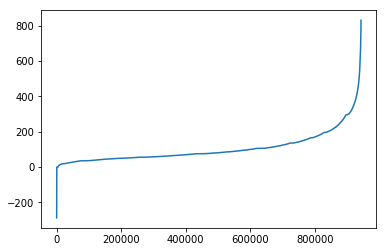

In [5]:
plt.plot(sorted(features['2_total_fee'])[:-1000])

In [6]:
du = train[train.duplicated(keep = False)]
du = du[du['current_service'] != 3]
du = du[du['current_service'] != 4]
train_x = train.drop_duplicates(keep = False).drop(['current_service', 'user_id'], axis = 1)
train_y = np.array(train.drop_duplicates(keep = False)['current_service'])
du_x = du.drop(['current_service', 'user_id'], axis = 1)
du_y = np.array(du['current_service'])
train_x = np.vstack([train_x, du_x])
train_y= np.hstack([train_y, du_y])

In [7]:
train_x, eval_x, train_y, eval_y = train_test_split(train_x, train_y, test_size = 0.3, random_state = 50)

In [8]:
def downSample(train_x, train_y, class_label, frac):
    trainData = pd.DataFrame(train_x)
    trainData['y'] = np.array(train_y)
    c = trainData[trainData['y'] == class_label]
    c = c.sample(frac = frac)
    trainData = trainData[trainData['y'] != class_label].copy()
    trainData = trainData.append(c)
    return trainData.drop(['y'], axis = 1), np.array(trainData['y'])
print("before:", train_x.shape)
train_x, train_y = downSample(train_x, train_y, 3, 0.4)
train_x, train_y = downSample(train_x, train_y, 4, 0.5)
train_x, train_y = downSample(train_x, train_y, 0, 0.85)
print("after:", train_x.shape)

before: (520790, 96)
after: (372657, 96)


In [9]:
# train_y = np.array(train_y == 10).astype(int)
# eval_y = np.array(eval_y == 10).astype(int)

In [10]:
len(train_x)

372657

In [ ]:
weight_dict = {0:1, 1:1, 2:1, 3:0.7, 4:0.9, 5:1, 6:1, 7:2, 8:2, 9:2, 10:2}
lgbm = lgb.LGBMClassifier(objective = "multiclass", boosting_type =  'gbdt', class_weight = None,
                          colsample_bytree = 0.625, importance_type = 'split', learning_rate = 0.5, max_depth = 9,
                         min_child_samples = 133, min_child_weight = 2, min_split_gain = 0.1, n_estimators = 2000, n_jobs = -1,
                         num_leaves = 58, random_state = 10, reg_alpha = 0.0005, reg_lambda = 0.0471,  subsample = 0.9375,
                        subsample_for_bin = 200000, subsample_freq = 1,verbosity = 0, verbose_eval = 100)
lgbm.fit(train_x, train_y, eval_set = (eval_x, eval_y), eval_metric = square_f1_score, early_stopping_rounds = 200)

[1]	valid_0's multi_logloss: 0.779635	valid_0's square_f1_score: 0.662804
Training until validation scores don't improve for 200 rounds.
[2]	valid_0's multi_logloss: 0.580986	valid_0's square_f1_score: 0.693817
[3]	valid_0's multi_logloss: 0.460298	valid_0's square_f1_score: 0.709368
[4]	valid_0's multi_logloss: 0.3846	valid_0's square_f1_score: 0.721282
[5]	valid_0's multi_logloss: 0.33662	valid_0's square_f1_score: 0.730648
[6]	valid_0's multi_logloss: 0.303916	valid_0's square_f1_score: 0.738772
[7]	valid_0's multi_logloss: 0.282454	valid_0's square_f1_score: 0.743023
[8]	valid_0's multi_logloss: 0.266161	valid_0's square_f1_score: 0.747768
[9]	valid_0's multi_logloss: 0.254409	valid_0's square_f1_score: 0.752595
[10]	valid_0's multi_logloss: 0.24475	valid_0's square_f1_score: 0.756167
[11]	valid_0's multi_logloss: 0.23775	valid_0's square_f1_score: 0.759695
[12]	valid_0's multi_logloss: 0.23168	valid_0's square_f1_score: 0.76299
[13]	valid_0's multi_logloss: 0.226827	valid_0's squa

[110]	valid_0's multi_logloss: 0.176573	valid_0's square_f1_score: 0.813056
[111]	valid_0's multi_logloss: 0.176501	valid_0's square_f1_score: 0.813306
[112]	valid_0's multi_logloss: 0.176371	valid_0's square_f1_score: 0.813654
[113]	valid_0's multi_logloss: 0.176226	valid_0's square_f1_score: 0.814031
[114]	valid_0's multi_logloss: 0.176198	valid_0's square_f1_score: 0.814146
[115]	valid_0's multi_logloss: 0.176119	valid_0's square_f1_score: 0.814228
[116]	valid_0's multi_logloss: 0.176057	valid_0's square_f1_score: 0.814348
[117]	valid_0's multi_logloss: 0.17599	valid_0's square_f1_score: 0.814504
[118]	valid_0's multi_logloss: 0.175913	valid_0's square_f1_score: 0.814573
[119]	valid_0's multi_logloss: 0.175768	valid_0's square_f1_score: 0.814663
[120]	valid_0's multi_logloss: 0.175705	valid_0's square_f1_score: 0.81489
[121]	valid_0's multi_logloss: 0.17557	valid_0's square_f1_score: 0.815185
[122]	valid_0's multi_logloss: 0.175528	valid_0's square_f1_score: 0.815248
[123]	valid_0's

In [277]:
pred = lgbm.predict(eval_x)
score = f1_score(eval_y, pred, average = 'macro')
print(score, np.square(score))

0.886655465855 0.786157915131


In [154]:
from sklearn.metrics import classification_report

In [306]:
test_feature = test.drop(['user_id'], axis = 1)
TestResult = test[['user_id']].copy()
TestResult['predict']  = lgbm.predict(test_feature)
TestResult['predict'] = TestResult['predict'].apply(lambda x: label_dict[x])

/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [307]:
TestResult.to_csv("../lgb8404.csv", index = None)

In [308]:
complex_pred = pd.read_csv("../lgb_xgb_complex_co1008.csv")
xgb_pred = pd.read_csv("../xgb_ox_2799743984766_0.8280.csv")
print(np.sum(TestResult.predict == complex_pred.predict))
print(np.sum(TestResult.predict == xgb_pred.predict))
print(np.sum(complex_pred.predict == xgb_pred.predict))

194973
194730
198897


In [191]:
from sklearn.metrics import classification_report
print(classification_report(eval_y, pred, digits = 3))
print(label_dict, end = "\n\n")

             precision    recall  f1-score   support

          0      0.992     0.996     0.994    216763
          1      0.848     0.735     0.787      6433

avg / total      0.988     0.989     0.988    223196

{0: 89950166, 1: 89950167, 2: 89950168, 3: 90063345, 4: 90109916, 5: 90155946, 6: 99999825, 7: 99999826, 8: 99999827, 9: 99999828, 10: 99999830, 99999825: 6, 99999826: 7, 99999827: 8, 99999828: 9, 89950166: 0, 89950167: 1, 89950168: 2, 99999830: 10, 90109916: 4, 90155946: 5, 90063345: 3}



In [146]:
      precision    recall  f1-score   support

          0      0.917     0.926     0.922     40270
          1      0.878     0.868     0.873     22125
          2      0.966     0.928     0.947     10030
          3      0.999     0.995     0.997     85873
          4      0.995     0.996     0.996     11329
          5      0.943     0.985     0.964      6665
          6      0.941     0.959     0.950      6114
          7      0.782     0.854     0.817      8738
          8      0.765     0.768     0.766      9679
          9      0.826     0.810     0.818     15940
         10      0.787     0.741     0.763      6433

avg / total      0.930     0.930     0.930    223196

SyntaxError: invalid syntax (<ipython-input-146-4b7186522729>, line 1)

In [155]:
sorted(dict(zip(du_x.columns, lgbm.feature_importances_)).items(), key = lambda x:x[1])

[('contract_time_21', 0),
 ('contract_time_26', 0),
 ('contract_time_27', 0),
 ('contract_time_28', 0),
 ('contract_time_8', 0),
 ('contract_time_16', 0),
 ('contract_time_25', 0),
 ('contract_time_12', 0),
 ('contract_time_20', 0),
 ('contract_time_7', 0),
 ('contract_time_5', 19),
 ('contract_time_6', 20),
 ('contract_time_-1', 21),
 ('contract_time_14', 25),
 ('contract_time_9', 26),
 ('contract_time_22', 35),
 ('contract_time_13', 36),
 ('gender1', 38),
 ('contract_time_17', 39),
 ('contract_time_23', 43),
 ('contract_time_19', 48),
 ('contract_time_15', 48),
 ('contract_time_11', 65),
 ('gender2', 98),
 ('is_mix_service', 119),
 ('contract_time_24', 125),
 ('gender0', 130),
 ('contract_time_29', 150),
 ('contract_time_18', 160),
 ('service_type', 161),
 ('contract_time_36', 254),
 ('contract_type', 254),
 ('contract_time_0', 259),
 ('contract_time_10', 267),
 ('contract_time_34', 268),
 ('contract_time_39', 315),
 ('many_over_bill', 404),
 ('contract_time_45', 430),
 ('contract_ti

In [235]:

def print_stats(tdf):
    dct = Counter(tdf)
    cn = len(tdf)
    for key in sorted(dct.keys()):
        print(key, round(dct[key]/cn, 3))
    print(cn, end = "\n\n")
print_stats(train_y)
print_stats(TestResult.predict)
print_stats(xgb_pred.predict)
print_stats(complex_pred.predict)

0 0.178
1 0.099
2 0.045
3 0.387
4 0.051
5 0.03
6 0.027
7 0.039
8 0.044
9 0.071
10 0.028
520790

89950166 0.084
89950167 0.101
89950168 0.019
90063345 0.58
90109916 0.05
90155946 0.035
99999825 0.015
99999826 0.026
99999827 0.022
99999828 0.045
99999830 0.023
200000

89950166 0.085
89950167 0.102
89950168 0.019
90063345 0.58
90109916 0.05
90155946 0.035
99999825 0.016
99999826 0.028
99999827 0.021
99999828 0.044
99999830 0.021
200000

89950166 0.086
89950167 0.102
89950168 0.019
90063345 0.58
90109916 0.05
90155946 0.035
99999825 0.016
99999826 0.028
99999827 0.021
99999828 0.044
99999830 0.02
200000

